# VRP Analysis — Stage 1

Does implied vol consistently overprice realized vol? If yes, that's a harvestable risk premium.

Using VIX as IV proxy, 21-day rolling for RV. Simple.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Data

In [2]:
spy = yf.download('SPY', start='2006-01-01', end='2024-12-31', progress=False)
vix = yf.download('^VIX', start='2006-01-01', end='2024-12-31', progress=False)

# handle yfinance multi-index quirk
spy_close = spy['Close']['SPY'] if isinstance(spy.columns, pd.MultiIndex) else spy['Close']
vix_close = vix['Close']['^VIX'] if isinstance(vix.columns, pd.MultiIndex) else vix['Close']

df = pd.DataFrame({'spy': spy_close, 'vix': vix_close}).dropna()
df['ret'] = np.log(df['spy'] / df['spy'].shift(1))
df['rv'] = df['ret'].rolling(21).std() * np.sqrt(252) * 100
df['vrp'] = df['vix'] - df['rv']
df = df.dropna()

print(f"{len(df)} daily obs")

C:\Users\cvand\AppData\Local\Temp\ipykernel_33824\206481720.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start='2006-01-01', end='2024-12-31', progress=False)


4759 daily obs


C:\Users\cvand\AppData\Local\Temp\ipykernel_33824\206481720.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start='2006-01-01', end='2024-12-31', progress=False)


## Does the premium exist?

In [3]:
# stats
print(f"Mean VRP:      {df['vrp'].mean():.2f} vol pts")
print(f"Median VRP:    {df['vrp'].median():.2f}")
print(f"% Positive:    {(df['vrp'] > 0).mean()*100:.1f}%")
print(f"Skew:          {df['vrp'].skew():.2f}")
print(f"Kurt:          {df['vrp'].kurtosis():.2f}")

# t-test w/ autocorr adjustment
rho = df['vrp'].autocorr()
eff_n = len(df) * (1-rho)/(1+rho)
t_adj = df['vrp'].mean() / (df['vrp'].std() / np.sqrt(eff_n))
print(f"\nAutocorr:      {rho:.2f}")
print(f"Adj t-stat:    {t_adj:.2f}  (eff N = {eff_n:.0f})")

Mean VRP:      3.55 vol pts
Median VRP:    3.99
% Positive:    84.5%
Skew:          -2.53
Kurt:          17.17

Autocorr:      0.92
Adj t-stat:    9.04  (eff N = 189)


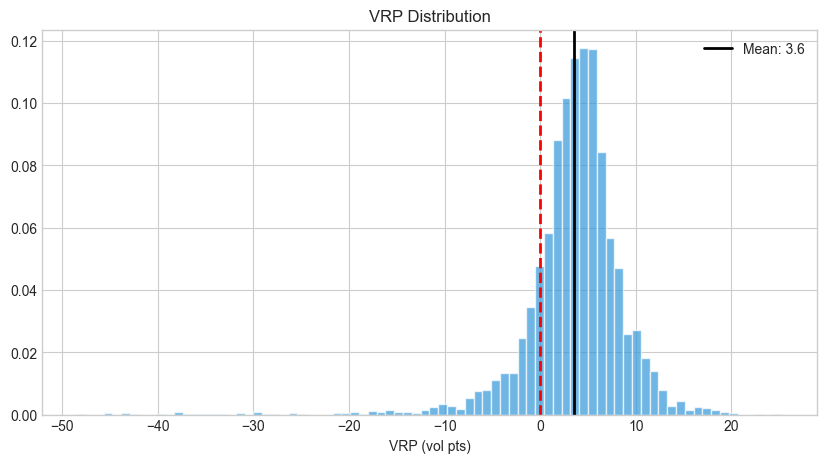

In [4]:
# distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df['vrp'], bins=80, density=True, alpha=0.7, color='#3498db', edgecolor='white')
ax.axvline(0, color='red', ls='--', lw=2)
ax.axvline(df['vrp'].mean(), color='black', lw=2, label=f'Mean: {df["vrp"].mean():.1f}')
ax.set_xlabel('VRP (vol pts)')
ax.set_title('VRP Distribution')
ax.legend()
plt.savefig('vrp_distribution.png', dpi=150)
plt.show()

## By regime

The premium should flip in crises — realized explodes past implied.

In [5]:
df['regime'] = pd.cut(df['vix'], bins=[0,15,20,25,35,100], labels=['<15','15-20','20-25','25-35','>35'])

regime = df.groupby('regime', observed=True).agg(
    mean_vrp=('vrp','mean'),
    std_vrp=('vrp','std'),
    pct=('vrp','count')
)
regime['pct'] = regime['pct'] / len(df) * 100
print(regime.round(2))

        mean_vrp  std_vrp    pct
regime                          
<15         3.29     2.57  35.97
15-20       4.03     3.98  28.93
20-25       4.30     4.90  17.31
25-35       4.66     5.44  12.57
>35        -2.44    15.25   5.21


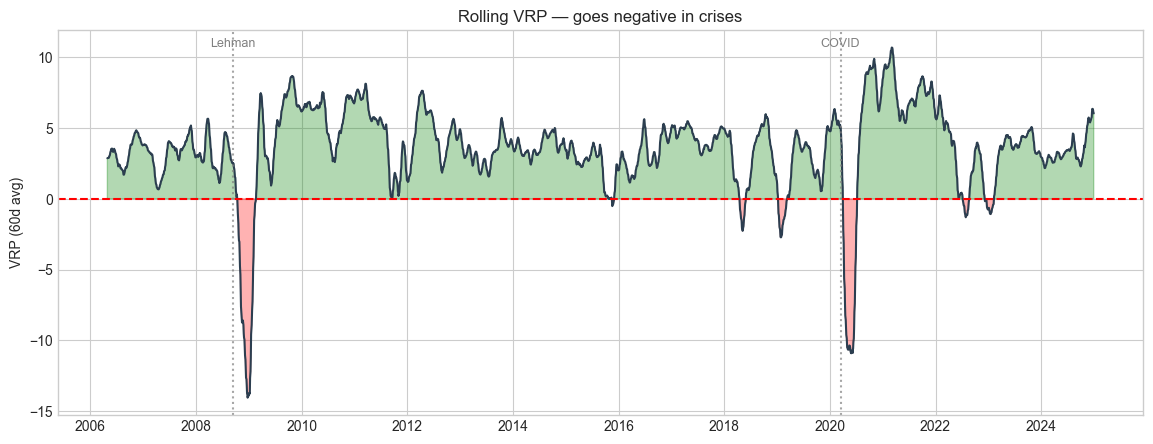

In [6]:
# rolling VRP
fig, ax = plt.subplots(figsize=(14, 5))
roll = df['vrp'].rolling(60).mean()
ax.plot(roll, color='#2c3e50', lw=1.5)
ax.fill_between(roll.index, 0, roll, where=roll>=0, alpha=0.3, color='green')
ax.fill_between(roll.index, 0, roll, where=roll<0, alpha=0.3, color='red')
ax.axhline(0, color='red', ls='--')
ax.set_ylabel('VRP (60d avg)')
ax.set_title('Rolling VRP — goes negative in crises')

for dt, lbl in [('2008-09-15','Lehman'), ('2020-03-15','COVID')]:
    ax.axvline(pd.Timestamp(dt), color='gray', ls=':', alpha=0.7)
    ax.text(pd.Timestamp(dt), ax.get_ylim()[1]*0.9, lbl, ha='center', fontsize=9, color='gray')

plt.savefig('vrp_regimes.png', dpi=150)
plt.show()

## Naive P&L simulation

Assume I can sell variance at VIX² and it realizes at RV². What's the strategy performance?

Monthly rebalance, vol-targeted.

In [7]:
# monthly
m = df.resample('ME').last().copy()
m['fwd_rv'] = df['ret'].resample('ME').std().shift(-1) * np.sqrt(252) * 100
m['pnl'] = (m['vix']**2 - m['fwd_rv']**2) / 100
m = m.dropna(subset=['pnl'])

# scale to 10% vol
scale = 0.10 / (m['pnl'].std() * np.sqrt(12))
m['ret_strat'] = m['pnl'] * scale
m['cum'] = (1 + m['ret_strat']).cumprod()

# SPY buy & hold for comparison
m['spy_ret'] = m['spy'].pct_change().fillna(0)
m['spy_cum'] = (1 + m['spy_ret']).cumprod()

print(f"{len(m)} months")

226 months


In [8]:
# performance
def perf(r):
    r = r.dropna()
    cum = (1 + r).cumprod()
    dd = cum / cum.expanding().max() - 1
    ann_r = (1 + r.mean())**12 - 1
    ann_v = r.std() * np.sqrt(12)
    return {'ret': ann_r, 'vol': ann_v, 'sharpe': ann_r/ann_v, 'maxdd': dd.min(), 'win': (r>0).mean()}

p = perf(m['ret_strat'])
print(f"Ann Return:   {p['ret']*100:.1f}%")
print(f"Ann Vol:      {p['vol']*100:.1f}%")
print(f"Sharpe:       {p['sharpe']:.2f}")
print(f"Max DD:       {p['maxdd']*100:.1f}%")
print(f"Win Rate:     {p['win']*100:.1f}%")

Ann Return:   3.8%
Ann Vol:      10.0%
Sharpe:       0.38
Max DD:       -36.0%
Win Rate:     81.0%


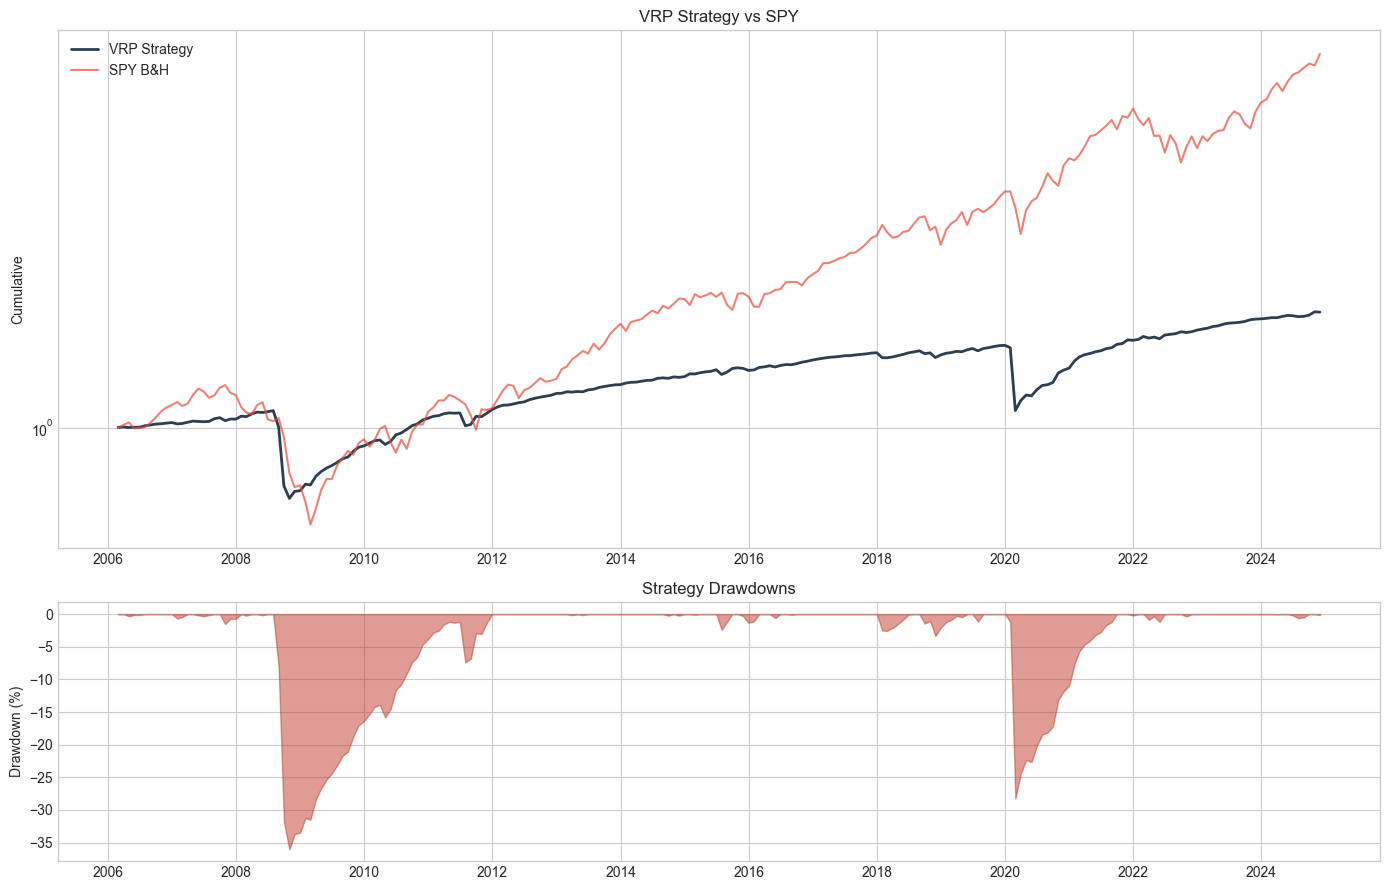

In [9]:
# equity curve
fig, axes = plt.subplots(2, 1, figsize=(14, 9), gridspec_kw={'height_ratios': [2,1]})

axes[0].plot(m['cum'], color='#2c3e50', lw=2, label='VRP Strategy')
axes[0].plot(m.index, m['spy_cum'], color='#e74c3c', lw=1.5, alpha=0.7, label='SPY B&H')
axes[0].set_ylabel('Cumulative')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_title('VRP Strategy vs SPY')

dd = m['cum'] / m['cum'].expanding().max() - 1
axes[1].fill_between(dd.index, dd*100, 0, color='#c0392b', alpha=0.5)
axes[1].set_ylabel('Drawdown (%)')
axes[1].set_title('Strategy Drawdowns')

plt.tight_layout()
plt.savefig('vrp_equity_curve.png', dpi=150)
plt.show()

In [10]:
# save for stage 2
df.to_csv('vrp_daily.csv')
m.to_csv('vrp_monthly.csv')
print('saved')

saved


## Takeaway

Premium exists (~3.5 vol pts, positive 85% of time). Sharpe ~0.38 unfiltered. Brutal left tail in crises.

Next: can regime filters help?